In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

bEdges = np.load('BandEdge.npy').item()
DefTot = np.load('DefectTotalEnergy.npy').item()
E0 = DefTot['default'][0]['0']
FreyCorr = np.load('FreysoldtCorrections.npy').item()
ChemPot = np.load('ChemicalReferences.npy').item()
SurfaceCalc = np.load('SurfCalc.npy').item()
text_def = np.load('LineLabels.npy').item()
colors = np.load('LineColors.npy').item()


def setChemPot(cond, delta={}):
    mu = {}
    mu['Zn'] = cond[0] + ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    mu['Ge'] = cond[1] + ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    mu['N'] = cond[2] + ChemPot['N'][0]/ChemPot['N'][1]['N']
    for ref in ChemPot:
        if len(ChemPot[ref][1]) == 1:
            for ele in ChemPot[ref][1]:
                if not ele in ['Zn', 'Ge', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele])
        elif len(ChemPot[ref][1]) == 2:
            for ele in ChemPot[ref][1]:
                if not ele in ['Zn', 'Ge', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
    return mu

def getPOSCARdiff(defect):
    default = {'Zn':32, 'Ge':32, 'N':64}
    n_mu = {}
    for i in DefTot[defect][1]:
        if i in default:
            n_mu[i] = DefTot[defect][1][i] - default[i]
        else: 
            n_mu[i] = DefTot[defect][1][i]
    return n_mu

def getLine(defect, cond, BandEdges = bEdges, Ef = np.arange(0, bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'],0.0001), charge = ''):
    chem = setChemPot(cond)
    defLoc = deepcopy(DefTot)
    defPar = defLoc[defect]
    n_mu = getPOSCARdiff(defect)
    levels = defPar[0]
    pLevels = {}
    #print levels
    #def_i_l = []
    
    if charge:
        if charge in FreyCorr[defect]:
            pass
    for i in levels:
        # add functionality to get defect levels: 
        # if str(int(i)-1) in levels:
        #    def_i_l += defPar[0][i] - defPar[0][str(int(i)-1)] - bEdges['ZnGeN2_VB']
            
        if i in FreyCorr[defect]:
            levels[i] += FreyCorr[defect][i]
        pLevels[i] = defPar[0][i] - E0 - sum(n_mu[j] * chem[j] for j in n_mu) + int(i) * (Ef + BandEdges['ZnGeN2_VB'])
    
    charges = [int(l) for l in pLevels]
    charges.sort()
    intlevels = {defect+' '+str(q)+'/'+str(q+1):round(pLevels[str(q)][0] - pLevels[str(q+1)][0],3) for q in charges[-len(charges):-1]}
    
    pDefect = np.minimum.reduce([pLevels[i] for i in pLevels])
    #print def_i_l
    return pDefect

from fractions import gcd
def FormEnth(Material):
    mat = ChemPot[Material]
    return (mat[0] - sum(ChemPot[ele][0]/ChemPot[ele][1][ele]* mat[1][ele] for ele in mat[1]))/reduce(gcd,[i for i in mat[1].values()])

def PlotForm(Defects, Condition, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure()
    ax = plt.subplot(111)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects[i]:
            ax.text(Defects[i][0],Defects[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)

In [5]:
def Figure1(Defects1,comp1, Defects2,comp2, Defects3,comp3, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure(figsize=(12,3)) 
    ax = plt.subplot(131)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects1:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Znpoor1, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects1[i]:
            ax.text(Defects1[i][0],Defects1[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
        if comp1:
            plt.plot([comp1, comp1],ylimits,'-.',color='#666666')
            ax.text(comp1+0.05,-1.9,r'$\epsilon_{F,comp}$',fontdict={'size':14},color='black')
    plt.ylabel('Formation Energy (eV)', fontsize=16)

    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
    ax.text(0.1, 2.4,u'(a)',fontdict={'size':20},color='black')
    plt.title('Li (Zn-poor)', fontsize=16)

    
    ax = plt.subplot(132)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects2:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Gepoor, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects2[i]:
            ax.text(Defects2[i][0],Defects2[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
        if comp2:
            plt.plot([comp2, comp2],ylimits,'-.',color='#666666')
            ax.text(comp2+0.05,-1.9,r'$\epsilon_{F,comp}$',fontdict={'size':14},color='black')
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticklabels([])
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.text(0.1, 2.4,u'(b)',fontdict={'size':20},color='black')
    plt.title('Al (Zn-rich)', fontsize=16)

    
    ax = plt.subplot(133)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects3:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Gepoor, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects3[i]:
            ax.text(Defects3[i][0],Defects3[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
        if comp3:
            plt.plot([comp3, comp3],ylimits,'-.',color='#666666')
            ax.text(comp3+0.05,-1.9,r'$\epsilon_{F,comp}$',fontdict={'size':14},color='black')
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticklabels([])
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
    ax.text(0.1, 2.4,u'(c)',fontdict={'size':20},color='black')

    plt.title('Ga (Zn-rich)', fontsize=16)

Znpoor1 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2, 0, FormEnth('Ge3N4')/4]
Znpoor2 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2/3, FormEnth('Ge3N4')/2/3, 0]
Gepoor = [0, FormEnth('ZnGeN2'), 0]
Npoor = [0, 0, FormEnth('ZnGeN2')/2]

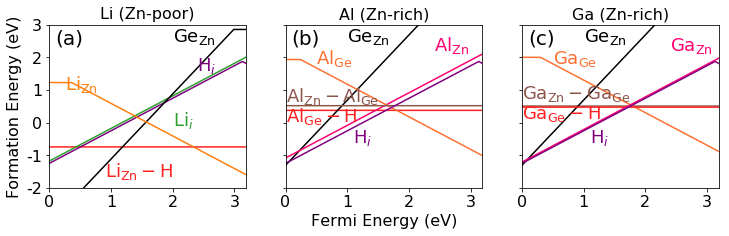

In [6]:
colors['Ge_Zn']='black'
Figure1({'Li_i':[2,-0.1], 'Li_Zn-H':[0.9,-1.65], 'Li_Zn':[0.25,1.0], 'H_i':[2.4,1.6], 'Ge_Zn':[2,2.5]}, 0,
        {'Al_Ge':[0.5,1.8], 'Al_Ge-H':[0.01,0.02], 'Al_Zn':[2.4,2.2], 'H_i':[1.1,-0.6], 'AlPair':[0.01,0.65],'Ge_Zn':[1,2.5]}, 0,
        {'Ga_Ge':[0.5,1.8], 'Ga_Ge-H':[0.01,0.11], 'Ga_Zn':[2.4,2.2], 'H_i':[1.1,-0.6], 'GaPair':[0.01,0.75],'Ge_Zn':[1,2.5]}, 0,           
         ylimits=[-2,3])




plt.savefig('G3_f1.png', bbox_inches='tight', format='png', dpi=300)
plt.savefig('G3_f2.eps', bbox_inches='tight', format='eps', dpi=300)


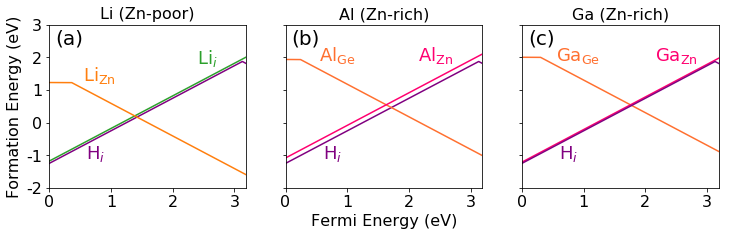

In [7]:
Figure1({'Li_i':[2.4,1.8], 'Li_Zn':[0.55,1.3], 'H_i':[0.6,-1.1]}, 0,
        {'Al_Ge':[0.55,1.9], 'Al_Zn':[2.15,1.9], 'H_i':[0.6,-1.1]}, 0,
        {'Ga_Ge':[0.55,1.9], 'Ga_Zn':[2.15,1.9], 'H_i':[0.6,-1.1]}, 0,           
         ylimits=[-2,3])




plt.savefig('G3_f1.png', bbox_inches='tight', format='png', dpi=300)
plt.savefig('LiAlGa.eps', bbox_inches='tight', format='eps', dpi=300)

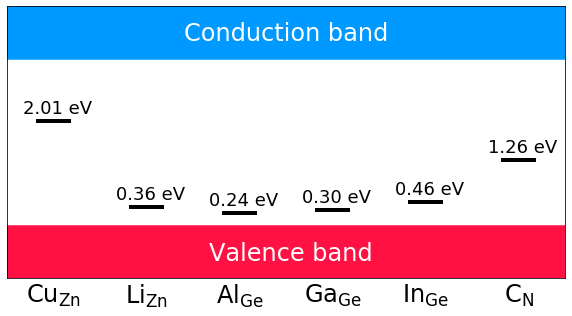

In [11]:
CB = bEdges['ZnGeN2_CB']
VB = bEdges['ZnGeN2_VB']

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,1.8])
ax.set_ylim([-1,CB-VB+1])
ax.set_xticks([]) 
ax.set_yticks([]) 



Cu_Zn_l = [2.007]
Li_Zn_l = [0.362]
Al_Ge_l = [0.241]
Ga_Ge_l = [0.301]
In_Ge_l = [0.457]
C_N_l =  [1.264]

plt.plot([0,1.8],[CB-VB,CB-VB],'#0099ff')
plt.plot([0,1.8],[0,0],'#ff1144')

ax.text(0.65, -0.65 ,u'Valence band',fontdict={'size':24},color='#ffffff')
ax.text(0.57, CB - VB +0.35 ,u'Conduction band',fontdict={'size':24},color='#ffffff')

ax.fill_between([0,1.8], -1, 0, facecolor='#ff1144')
ax.fill_between([0,1.8], CB-VB, CB-VB+1, facecolor='#0099ff')

for i in Cu_Zn_l:
    plt.plot([0.1,0.2],[i,i],'black', lw=4) 
    ax.text(0.05, i+0.15 ,u'2.01 eV',fontdict={'size':18},color='black')


for i in Li_Zn_l:
    plt.plot([0.4,0.5],[i,i],'black', lw=4) 
    ax.text(0.35, i+0.15 ,u'0.36 eV',fontdict={'size':18},color='black')

for i in Al_Ge_l:
    plt.plot([0.7,0.8],[i,i],'black', lw=4) 
    ax.text(0.65, i+0.15 ,u'0.24 eV',fontdict={'size':18},color='black')

for i in Ga_Ge_l:
    plt.plot([1.0,1.1],[i,i],'black', lw=4) 
    ax.text(0.95, i+0.15 ,u'0.30 eV',fontdict={'size':18},color='black')

for i in In_Ge_l:
    plt.plot([1.3,1.4],[i,i],'black', lw=4) 
    ax.text(1.25, i+0.15 ,u'0.46 eV',fontdict={'size':18},color='black')
    
for i in C_N_l:
    plt.plot([1.6,1.7],[i,i],'black', lw=4) 
    ax.text(1.55, i+0.15 ,u'1.26 eV',fontdict={'size':18},color='black')
    
ax.set_xticks([0.15, 0.45, 0.75, 1.05, 1.35, 1.65])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([r'$\rmCu_{Zn}$', r'$\rmLi_{Zn}$', r'$\rmAl_{Ge}$', r'$\rmGa_{Ge}$', r'$\rmIn_{Ge}$', r'$\rmC_{N}$'],fontdict={'size':24},color='black')

plt.savefig('DopantLevels.png', bbox_inches='tight', format='png', dpi=300)
plt.savefig('DopantLevels.eps', bbox_inches='tight', format='eps', dpi=300)


In [12]:
bEdges

{'GaN25_CB': 5.245438,
 'GaN25_VB': 2.062347,
 'GaN295_CB': 5.447876,
 'GaN295_VB': 1.965016,
 'ZnGeN2_CB': 5.98107,
 'ZnGeN2_VB': 2.791913,
 'ZnSiN2_CB': 8.840683,
 'ZnSiN2_VB': 4.009651,
 'ZnSnN2_CB': 4.613189,
 'ZnSnN2_VB': 3.208647}